In [55]:
import pandas as pd 
import numpy as np
import os
from notears.notears import linear
from notears.notears import utils

# Test

In [2]:
data_dir = '/cim/ehoney/IFT6168_project/dcdi/data/perfect/data_p10_e10_n10000_linear_struct'

In [3]:
dag_path = os.path.join(data_dir, 'DAG1.npy')
cpdag_path = os.path.join(data_dir, 'CPDAG1.npy')
obs_data_path = os.path.join(data_dir, 'data1.npy')
interv_data_path = os.path.join(data_dir, 'data_interv1.npy')
regime_idx_path = os.path.join(data_dir, 'regime1.csv')
interv_nodes_path = os.path.join(data_dir, 'intervention1.csv')

In [5]:
dag = np.load(dag_path)
dag

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
cpdag = np.load(cpdag_path)
cpdag

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
obs_data = np.load(obs_data_path)
obs_data

array([[ 1.04549416,  1.56876855,  0.50505903, ..., -1.55214666,
        -0.67011774, -0.95467569],
       [ 0.83139287,  0.29945842, -0.56516481, ..., -0.82588713,
        -1.0324189 , -0.20330703],
       [-1.53261836, -2.29737887,  0.70926069, ...,  1.30303601,
         2.05855852,  0.90334801],
       ...,
       [-1.68027651, -1.29201461,  0.36296983, ...,  0.20386925,
         0.3136674 ,  1.03691721],
       [ 0.73037723,  0.7762301 ,  0.5579628 , ..., -0.08943212,
        -1.72667629, -0.31639158],
       [-2.34830366, -2.29520103, -0.47288351, ...,  1.47536252,
         1.07835087,  2.56914919]])

In [8]:
regime_df = pd.read_csv(regime_idx_path)
regime_df

,10
0,10
1,10
2,10
3,10
4,10
...,...
9994,0
9995,0
9996,0
9997,0


In [9]:
interv_nodes_df = pd.read_csv(interv_nodes_path)
interv_nodes_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
9085,3
9086,3
9087,3
9088,3


In [10]:
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid


def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est

In [12]:
# Run NOTears on obs_data
lambda1 = 0.1  # L1 penalty parameter
loss_type = 'l2'  # Loss type (choose 'l2', 'logistic', or 'poisson')
w_threshold = 0.3 #suggested from paper

W_est = linear.notears_linear(obs_data, lambda1=lambda1, loss_type=loss_type)
W_est[np.abs(W_est) < w_threshold] = 0

output_path = "/cim/ehoney/IFT6168_project/no_tears_test.csv"
np.savetxt(output_path, W_est, delimiter=",")


In [30]:
W_est

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.39965325,  0.        ,  0.        , -0.69003791],
       [ 0.57595125,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.59188953, -0.77102606,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.76193059,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.71082203,  0.        ,  0.        ,  0.        ,
         0.        , -0.82904412,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [41]:
utils.count_accuracy(dag, dag_est)

{'fdr': 0.625, 'tpr': 0.375, 'fpr': 0.13513513513513514, 'shd': 6, 'nnz': 8}

In [34]:
dag_est = (W_est != 0).astype(int)

In [35]:
dag_est

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
dag

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
np.sum(np.abs(dag - dag_est))

10.0

In [37]:
np.sum(dag != dag_est)

10

In [47]:
def structure_hamming_dist(
    adj_mat, other_adj_mat, double_for_anticausal: bool = True
) -> float:
    """Compute structural hamming distance.

    The Structural Hamming Distance (SHD) is a standard distance to compare
    graphs by their adjacency matrix. It consists in computing the difference
    between the two (binary) adjacency matrixes: every edge that is either
    missing or not in the target graph is counted as a mistake. Note that
    for directed graph, two mistakes can be counted as the edge in the wrong
    direction is false and the edge in the good direction is missing; the
    ``double_for_anticausal`` argument accounts for this remark. Setting it to
    `False` will count this as a single mistake.

    Parameters
    ----------
    true_graph : instance of nx.Graph or nx.DiGraph
        The true graph as an instance of a MixedEdgeGraph with only one type of
        edge.
    pred_graph : instance of nx.Graph or nx.DiGraph
        The predicted graph. The predicted graph and true graph must be
        the same type.
    double_for_anticausal : bool, optional
        Whether to count incorrect orientations as two mistakes, by default True

    Returns
    -------
    shd : float
        The hamming distance between 0 and infinity.

    Notes
    -----
    SHD is only well defined if you have a graph with only undirected edges,
    or directed edges. That is, we only consider a Bayesian network, or a causal
    DAG as candidates. If there are more than one type of edge within
    the network, then SHD can be called on a sub-graph of that edge type. For example,
    say you would like to compare a PAG, where there are directed, undirected, bidirected
    and edges with circular endpoints. Currently, there is no known way of comparing
    two PAGs systematically. Therefore, one can compare PAGs via the number of circle
    edges, or the SHD of the undirected, bidirected, directed edge subgraphs.
    """

    # convert graphs to adjacency matrix in numpy array format
    # adj_mat = nx.to_numpy_array(true_graph)[np.ix_(idx, idx)]
    # other_adj_mat = nx.to_numpy_array(pred_graph)[np.ix_(other_idx, other_idx)]

    diff = np.abs(adj_mat - other_adj_mat)

    if double_for_anticausal:
        return np.sum(diff)
    else:
        diff = diff + diff.T
        diff[diff > 1] = 1  # Ignoring the double edges.
        return np.sum(diff) / 2

In [50]:
structure_hamming_dist(dag, dag_est, double_for_anticausal=True)

10.0

In [40]:
compute_shd(dag, dag_est)

10

In [53]:
def edge_errors(true_labels, predictions):
    """
    Counts all types of edge errors (false negatives, false positives, reversed edges)

    Parameters:
    -----------
    pred: nx.DiGraph or ndarray
        The predicted adjacency matrix
    target: nx.DiGraph or ndarray
        The true adjacency matrix

    Returns:
    --------
    fn, fp, rev

    """

    diff = true_labels - predictions

    rev = (((diff + diff.transpose()) == 0) & (diff != 0)).sum() / 2
    # Each reversed edge necessarily leads to one fp and one fn so we need to subtract those
    fn = (diff == 1).sum() - rev
    fp = (diff == -1).sum() - rev

    return fn, fp, rev

In [54]:
edge_errors(dag, dag_est)

(1.0, 1.0, 4.0)

In [ ]:
import cdt
sid = float(cdt.metrics.SID(target=dag, pred=dag_est))

In [62]:
sid

23.0

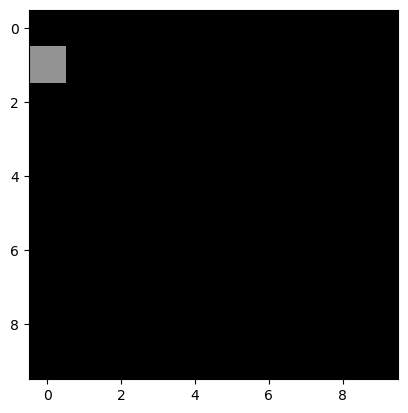

In [26]:
import matplotlib.pyplot as plt

plt.imshow(W_est)

# Test all datasets

In [ ]:
# Dictionary to store SHD values and statistics for each data directory
shd_stats_per_dir = {}

# List of data directories to iterate through
data_dirs = [
    os.path.join('/home/ethan/IFT6168/project/dcdi/data/perfect', d)
    for d in os.listdir('/home/ethan/IFT6168/project/dcdi/data/perfect')
    if os.path.isdir(os.path.join('/home/ethan/IFT6168/project/dcdi/data/perfect', d)) and d != 'sachs_intervention'
]

# Iterate through each data directory
for data_dir in data_dirs:
    print(f"Processing data directory: {data_dir}")
    
    shd_values = []  # Reset SHD values for the current directory
    
    # Iterate through the 10 datasets in the current directory
    for i in range(1, 11):
        # Load the DAG and observational data
        dag_path = os.path.join(data_dir, f'DAG{i}.npy')
        obs_data_path = os.path.join(data_dir, f'data{i}.npy')
        
        dag = np.load(dag_path)  # Ground truth DAG
        obs_data = np.load(obs_data_path)  # Observational data
        
        # Run NOTEARS linear
        lambda1 = 0.1  # Regularization parameter
        w_threshold = 0.3  # Threshold for edge weights
        W_est = linear.notears_linear(obs_data, lambda1=lambda1, loss_type='l2')
        W_est[np.abs(W_est) < w_threshold] = 0  # Apply thresholding
        
        # Compute the SHD (Structural Hamming Distance)
        shd = np.sum((W_est != 0) != (dag != 0))  # Compare adjacency matrices
        shd_values.append(shd)
        
        # Print the SHD for the current dataset
        print(f"Dataset {i}: SHD = {shd}")
    
    # Compute the mean and variance of SHD values for the current directory
    mean_shd = np.mean(shd_values)
    variance_shd = np.var(shd_values)
    
    # Store the full SHD values and statistics in the dictionary
    shd_stats_per_dir[data_dir] = {
        'shd_values': shd_values,
        'mean_shd': mean_shd,
        'variance_shd': variance_shd
    }
    
    print(f"Mean SHD for {data_dir}: {mean_shd}")
    print(f"Variance of SHD for {data_dir}: {variance_shd}")

# Display the SHD statistics for all directories
print("SHD Statistics per Data Directory:")
print(shd_stats_per_dir)

Processing data directory: /home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nnadd_struct
Dataset 1: SHD = 9
Dataset 2: SHD = 16
Dataset 3: SHD = 5
Dataset 4: SHD = 21
Dataset 5: SHD = 13
Dataset 6: SHD = 8
Dataset 7: SHD = 19
Dataset 8: SHD = 13
Dataset 9: SHD = 10
Dataset 10: SHD = 14
Mean SHD for /home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nnadd_struct: 12.8
Variance of SHD for /home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nnadd_struct: 22.360000000000003
Processing data directory: /home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nn_struct
Dataset 1: SHD = 11
Dataset 2: SHD = 14
Dataset 3: SHD = 9
Dataset 4: SHD = 14
Dataset 5: SHD = 13
Dataset 6: SHD = 13
Dataset 7: SHD = 12
Dataset 8: SHD = 9
Dataset 9: SHD = 7
Dataset 10: SHD = 11
Mean SHD for /home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nn_struct: 11.3
Variance of SHD for /home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n100

In [74]:
data_dirs

['/home/ethan/IFT6168/project/dcdi/data/perfect/sachs_intervention',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nnadd_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_nn_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e40_n10000_nnadd_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p20_e80_n10000_nn_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p20_e20_n10000_nn_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p20_e80_n10000_nnadd_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e40_n10000_linear_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e10_n10000_linear_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p10_e40_n10000_nn_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p20_e80_n10000_linear_struct',
 '/home/ethan/IFT6168/project/dcdi/data/perfect/data_p20_e20_n10000_linear_struct',
 '/home/ethan/IFT6168/proj